<a href="https://colab.research.google.com/github/bhimrazy/COVID-19-Detection-from-CXR-with-Transfer-Learning-using-PyTorch/blob/main/COVID_19_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
@author: Bhimraj Yadav
Title: COVID-19 Detection with Transfer Learning using PyTorch
"""

'\n@author: Bhimraj Yadav\nTitle: COVID-19 Detection with Transfer Learning using PyTorch\n'

In [25]:
#downlaoding datasets
!gdown "https://drive.google.com/uc?id=1bum9Sehb3AzUMHLhBMuowPKyr_PCrB3a"

#unzipping files
!unzip COVID-19_Radiography_Dataset.zip

# removing zip file
!rm -rf COVID-19_Radiography_Dataset.zip


In [3]:
# preparation

import os 
import glob
import shutil
import random
from tqdm import tqdm

# removing datasets folder if already exists 
if (os.path.exists("datasets")):
  shutil.rmtree("datasets/")

root_folder="COVID-19_Radiography_Dataset"
classes = ["COVID","Lung_Opacity","Viral Pneumonia","Normal"]

# prepairing datasets folders
for cat in ["train","val","test"]:
  for c in classes:
    os.makedirs(f"datasets/{cat}/{c}", exist_ok = True)
    os.makedirs(f"datasets/{cat}/{c}", exist_ok = True)

# copying files to new folders
random.seed(230)

data_distribution ={}

for cls in classes:
  filenames = glob.glob(f"{root_folder}/{cls}/images/*")
  filenames.sort()  # make sure that the filenames have a fixed order before shuffling
  random.shuffle(filenames) # shuffles the ordering of filenames (deterministic given the chosen seed)

  split_1 = int(0.8 * len(filenames))
  split_2 = int(0.9 * len(filenames))
  files={
      "train": filenames[:split_1],
      "val": filenames[split_1:split_2],
      "test" :filenames[split_2:]
  }
  data = {}
  for k,file_names in tqdm(files.items(),cls):
    data[k]=len(file_names)
    for i,file_path in enumerate(file_names):
      file_cat = file_path.split("/")[-3]
      file_name = f"{file_cat}_{i+1}.png"
      dest = f"datasets/{k}/{file_cat}/"+file_name
      shutil.copyfile(file_path,dest)
  
  data_distribution[cls]=data

Normal: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


In [4]:
import pandas as pd
pd.options.plotting.backend = "plotly"

In [5]:
df = pd.DataFrame(data_distribution)
fig = df.plot.bar(title="Data Distribution",
              labels=dict(index="Data Category", value="Numbers", variable="Classes"))
fig.show()

In [6]:
# importing libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([ 
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=2)
              for x in ['train','val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
image_datasets

{'test': Dataset ImageFolder
     Number of datapoints: 2119
     Root location: datasets/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'train': Dataset ImageFolder
     Number of datapoints: 16930
     Root location: datasets/train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 2116
     Root location: 

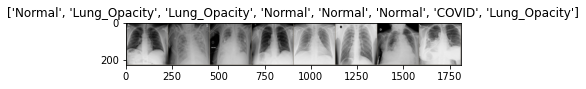

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
# define model

class DenseNet121(nn.Module):
    """DenseNet121 pretrained model definition."""
    def __init__(self,out_size:int):
        super(DenseNet121,self).__init__()
        self.model = torchvision.models.densenet121(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
                nn.Linear(in_features,in_features*2),
                nn.Dropout(0.5),
                nn.Linear(in_features*2,in_features),
                nn.Dropout(0.30),
                nn.Linear(in_features,in_features//2),
                nn.Dropout(0.25),
                nn.Linear(in_features//2,out_size),
                nn.Softmax()
            )
    def forward(self,x):
        return self.model(x)

model = DenseNet121(out_size=4)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [19]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



train Loss: 0.9361 Acc: 0.8041
val Loss: 0.9021 Acc: 0.8360

Epoch 1/19
----------
train Loss: 0.9423 Acc: 0.7969
val Loss: 0.9047 Acc: 0.8360

Epoch 2/19
----------
train Loss: 0.9362 Acc: 0.8035
val Loss: 0.8995 Acc: 0.8388

Epoch 3/19
----------
train Loss: 0.9359 Acc: 0.8044
val Loss: 0.9108 Acc: 0.8275

Epoch 4/19
----------
train Loss: 0.9347 Acc: 0.8050
val Loss: 0.9040 Acc: 0.8374

Epoch 5/19
----------
train Loss: 0.9326 Acc: 0.8073
val Loss: 0.9057 Acc: 0.8336

Epoch 6/19
----------
train Loss: 0.9333 Acc: 0.8075
val Loss: 0.9007 Acc: 0.8417

Epoch 7/19
----------
train Loss: 0.9217 Acc: 0.8182
val Loss: 0.9000 Acc: 0.8393

Epoch 8/19
----------
train Loss: 0.9187 Acc: 0.8220
val Loss: 0.8980 Acc: 0.8440

Epoch 9/19
----------
train Loss: 0.9181 Acc: 0.8214
val Loss: 0.8933 Acc: 0.8450

Epoch 10/19
----------
train Loss: 0.9206 Acc: 0.8184
val Loss: 0.8982 Acc: 0.8412

Epoch 11/19
----------
train Loss: 0.9184 Acc: 0.8218
val Loss: 0.8957 Acc: 0.8483

Epoch 12/19
----------
t

In [20]:
model_conv = train_model(model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



train Loss: 0.9165 Acc: 0.8251
val Loss: 0.8938 Acc: 0.8450

Epoch 1/19
----------
train Loss: 0.9161 Acc: 0.8243
val Loss: 0.8870 Acc: 0.8544

Epoch 2/19
----------
train Loss: 0.9153 Acc: 0.8252
val Loss: 0.8932 Acc: 0.8459

Epoch 3/19
----------
train Loss: 0.9186 Acc: 0.8214
val Loss: 0.8975 Acc: 0.8431

Epoch 4/19
----------
train Loss: 0.9144 Acc: 0.8271
val Loss: 0.8974 Acc: 0.8417

Epoch 5/19
----------
train Loss: 0.9134 Acc: 0.8278
val Loss: 0.9031 Acc: 0.8351

Epoch 6/19
----------
train Loss: 0.9197 Acc: 0.8206
val Loss: 0.8932 Acc: 0.8478

Epoch 7/19
----------
train Loss: 0.9126 Acc: 0.8277
val Loss: 0.8920 Acc: 0.8478

Epoch 8/19
----------
train Loss: 0.9162 Acc: 0.8242
val Loss: 0.9007 Acc: 0.8426

Epoch 9/19
----------
train Loss: 0.9163 Acc: 0.8233
val Loss: 0.8931 Acc: 0.8521

Epoch 10/19
----------
train Loss: 0.9133 Acc: 0.8271
val Loss: 0.8983 Acc: 0.8417

Epoch 11/19
----------
train Loss: 0.9152 Acc: 0.8252
val Loss: 0.8954 Acc: 0.8440

Epoch 12/19
----------
t

In [21]:
torch.save(model_conv, "covid-19.pt")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



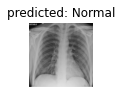

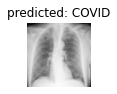

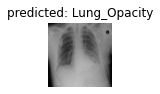

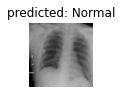

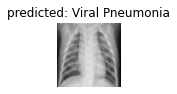

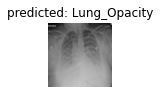

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [15]:
from sklearn.metrics import classification_report,confusion_matrix,log_loss
def gen_metrics(preds,labels):
  _, preds = torch.max(preds, 1)
  labels  = labels.detach().cpu().numpy()
  preds   = preds.detach().cpu().numpy()
  target_names = classes
  print(classification_report(labels,preds, target_names=target_names))

  #Generate the confusion matrix
  cf_matrix = confusion_matrix(labels,preds)
  print("cf_matrix")
  print(cf_matrix)

  print("lg_loss")
  lg_loss = log_loss(labels,preds)
  print(lg_loss)

val_d = torch.utils.data.DataLoader(image_datasets["val"],batch_size=100)
test_d = torch.utils.data.DataLoader(image_datasets["test"],batch_size=100)

labels_v = []
outputs_v = []

labels_t = []
outputs_t = []

model_conv.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_d):
        inputs = inputs.to(device)
        labels_v += labels.to(device)
        outputs_v += model_conv(inputs)

model_conv.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_d):
        inputs = inputs.to(device)
        labels_t += labels.to(device)
        outputs_t += model_conv(inputs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



In [16]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def gen_metrics(preds,labels):
  preds = [torch.argmax(pred).detach().cpu().item() for pred in preds]
  labels  = [label.detach().cpu().item() for label in labels]
  target_names = ["COVID","Lung_Opacity","Viral Pneumonia","Normal"]
  print(classification_report(labels,preds,target_names=target_names))

  #Generate the confusion matrix
  cm = confusion_matrix(labels,preds)
  plt.figure(figsize=(10,10))
  plot_confusion_matrix(cm, target_names)


                 precision    recall  f1-score   support

          COVID       0.83      0.72      0.77       362
   Lung_Opacity       0.85      0.77      0.81       601
Viral Pneumonia       0.84      0.92      0.87      1019
         Normal       0.85      0.87      0.86       134

       accuracy                           0.84      2116
      macro avg       0.84      0.82      0.83      2116
   weighted avg       0.84      0.84      0.84      2116

Confusion matrix, without normalization
[[260  32  67   3]
 [ 32 463 102   4]
 [ 22  49 934  14]
 [  1   3  14 116]]


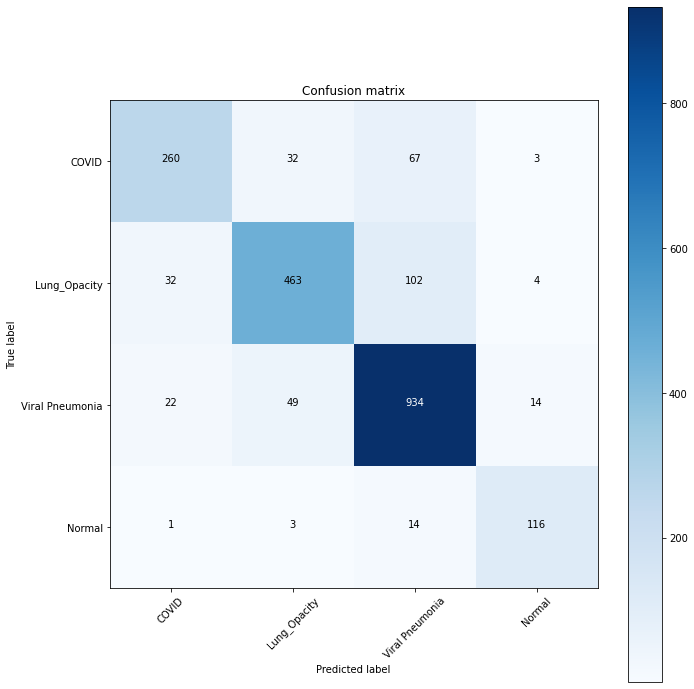

In [17]:
#Generate metrics for val data
gen_metrics(outputs_v,labels_v)

                 precision    recall  f1-score   support

          COVID       0.84      0.71      0.77       362
   Lung_Opacity       0.82      0.80      0.81       602
Viral Pneumonia       0.84      0.91      0.88      1020
         Normal       0.90      0.86      0.88       135

       accuracy                           0.84      2119
      macro avg       0.85      0.82      0.83      2119
   weighted avg       0.84      0.84      0.84      2119

Confusion matrix, without normalization
[[257  31  69   5]
 [ 30 484  86   2]
 [ 19  69 926   6]
 [  1   3  15 116]]


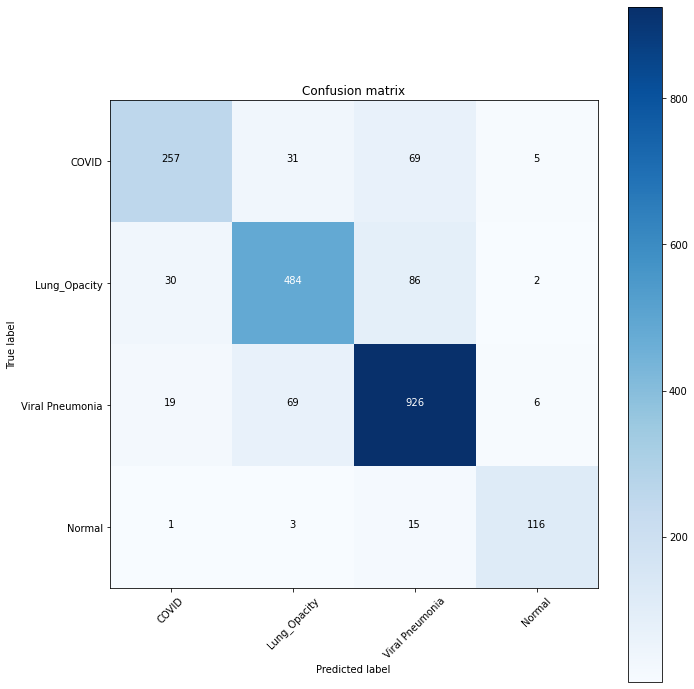

In [18]:
#Generate metrics for test data
gen_metrics(outputs_t,labels_t)